In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
DIRECTORY = r"F:\CVPR/final/assigment/dataset"
CATEGORIES = ["with_mask","mask_weared_incorrect","without_mask"]


In [6]:
print("[INFO] loading images...")

[INFO] loading images...


In [7]:
data = []
labels = []

In [8]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224)) #all images will be 224 x 224
    	image = img_to_array(image) #images to array using imagetoarray function
    	image = preprocess_input(image) # mobileNet used for model so, we used preprocess_input fuction

    	data.append(image)
    	labels.append(category)

c:\Users\Meraz\.conda\envs\cvpr\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
lb = LabelBinarizer() 
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

#train & test data 0.2 for testing and 0.8 for training
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [11]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [12]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 5s 1us/step


In [13]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel) #creating the pooling 7 by 7
headModel = Flatten(name="flatten")(headModel) #doing flatten this layers
headModel = Dense(128, activation="relu")(headModel) # dense layer and relu is non-linear use cases.
headModel = Dropout(0.5)(headModel) #dropout for avoiding 
headModel = Dense(2, activation="softmax")(headModel) 

In [14]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [15]:
for layer in baseModel.layers:
	layer.trainable = False

In [16]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


c:\Users\Meraz\.conda\envs\cvpr\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 111s 1s/step - loss: 0.4189 - accuracy: 0.8342 - val_loss: 0.1530 - val_accuracy: 0.9831
Epoch 2/20
95/95 [==============================] - 102s 1s/step - loss: 0.1523 - accuracy: 0.9618 - val_loss: 0.0709 - val_accuracy: 0.9922
Epoch 3/20
95/95 [==============================] - 103s 1s/step - loss: 0.1000 - accuracy: 0.9753 - val_loss: 0.0529 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 102s 1s/step - loss: 0.0778 - accuracy: 0.9773 - val_loss: 0.0429 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 100s 1s/step - loss: 0.0683 - accuracy: 0.9786 - val_loss: 0.0393 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 102s 1s/step - loss: 0.0595 - accuracy: 0.9842 - val_loss: 0.0342 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 100s 1s/step - loss: 0.0521 - accuracy: 0.9871 - val_loss: 0.0344 - val_accura

In [18]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
24/24 [==============================] - 19s 731ms/step


In [19]:
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [20]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


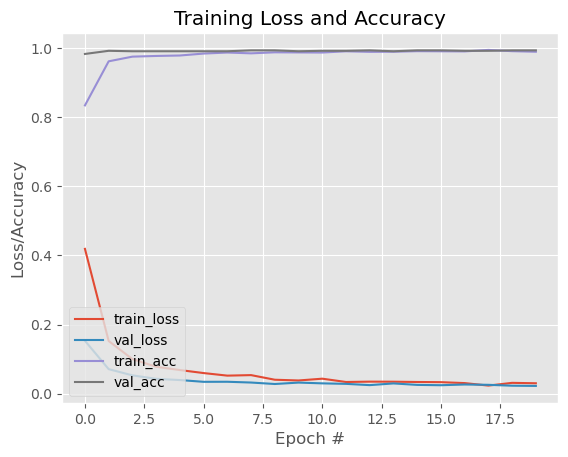

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")